   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data column

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,predicted_charges
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1,17258.671875
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0,2074.386719
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0,5108.266113
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0,19256.349609
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0,2655.161133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0,10539.315430
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0,2463.596924
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0,1354.081177
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1,2107.958984


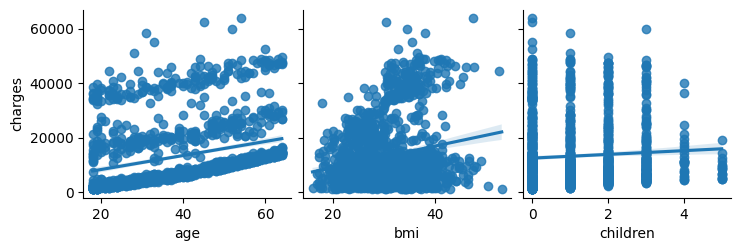

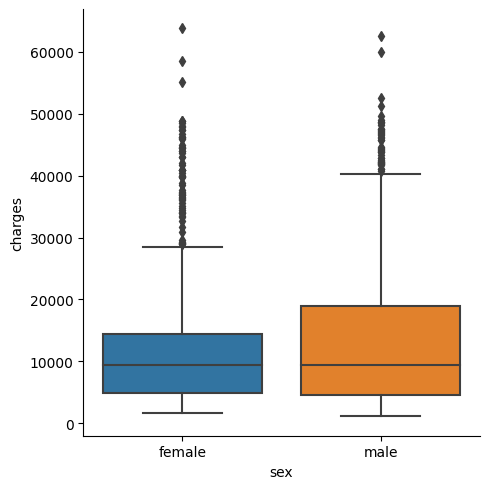

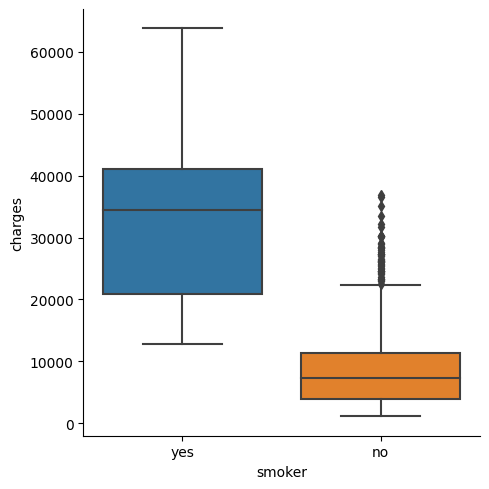

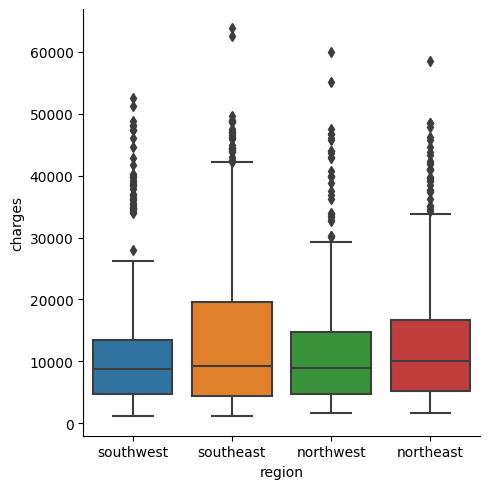

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Load data
data = pd.read_csv("/content/insurance.csv")

# EDA
print(data.head())
print(data.describe())
print(data.info())
print(data.isnull().sum())

# Visualize the relationships between the features and the target variable
import seaborn as sns
sns.pairplot(data, x_vars=['age', 'bmi', 'children'], y_vars='charges', kind='reg')
sns.catplot(x='sex', y='charges', data=data, kind='box')
sns.catplot(x='smoker', y='charges', data=data, kind='box')
sns.catplot(x='region', y='charges', data=data, kind='box')

# Preprocess the data
X = data.drop('charges', axis=1)
y = data['charges']
encoder = OneHotEncoder(drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X[['sex', 'smoker', 'region']]).toarray(),
                         columns=encoder.get_feature_names_out(['sex', 'smoker', 'region']))

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X[['age', 'bmi', 'children']]), columns=['age', 'bmi', 'children'])
X_processed = pd.concat([X_encoded, X_scaled], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



# Convert categorical variables into dummy/indicator variables
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])

# Split data into features (X) and target variable (y)
X = data.drop('charges', axis=1)
y = data['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and evaluate linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print("Linear Regression Model:")
print("Mean Squared Error: ", lr_mse)
print("R-squared: ", lr_r2)

# Build and evaluate XGBoost regression model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print("\nXGBoost Regression Model:")
print("Mean Squared Error: ", xgb_mse)
print("R-squared: ", xgb_r2)

# Select the best model
if lr_r2 > xgb_r2:
    best_model = lr_model
else:
    best_model = xgb_model

# Generate predictions for healthcare charges for each customer
predictions = best_model.predict(X)

# Save predictions to a new column in the dataframe
data['predicted_charges'] = predictions
data